In [23]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

from preprocessing.utils import *

In [7]:
!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

In [14]:
dataset = 'clf_num/bank-marketing.csv'
dataset2 = 'clf_cat/electricity.csv'
REPO_ID = "inria-soda/tabular-benchmark"

In [15]:
df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset2, repo_type="dataset")
)
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.898987,2,0.957447,0.068632,0.568283,0.004456,0.456499,0.644737,DOWN
1,0.867616,5,0.234043,0.033716,0.337102,0.001672,0.329622,0.846930,DOWN
2,0.009159,6,0.255319,0.059175,0.185808,0.003467,0.422915,0.414912,DOWN
3,0.898987,2,0.531915,0.087577,0.539572,0.004936,0.637752,0.491667,DOWN
4,0.868280,6,0.085106,0.027021,0.165129,0.001271,0.265924,0.748246,DOWN
...,...,...,...,...,...,...,...,...,...
38469,0.915800,6,0.404255,0.077549,0.456263,0.005332,0.378560,0.356140,UP
38470,0.915800,6,0.425532,0.074397,0.444213,0.005110,0.377525,0.369737,UP
38471,0.915800,6,0.468085,0.072835,0.423386,0.005019,0.354480,0.380263,UP
38472,0.915800,6,0.829787,0.065420,0.353913,0.004508,0.319524,0.319737,UP


In [27]:
np.random.seed(42)
clf_cat_xgboost_scores = []

df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset2, repo_type="dataset")
)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=True)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)

# XGBoost
print('Running XGBoosting')
hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = XGBClassifier()
    else :
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = XGBClassifier(**hyperparameters)
    iteration_n += 1
    # score = -np.mean(cross_val_score(model, train_data.iloc[:, :-1], train_data.iloc[:, -1], cv=5, scoring='accuracy'))
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = -accuracy_score(y_val, y_predict)

    return score

trials = Trials()
iteration_n = 0
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = -1 * np.array(trials.losses())

with open(f'best_clf_cat_xgboost_params.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)
clf_cat_xgboost_scores = scores_round.tolist()



Removed 0 rows with missing values on 38474 rows
Removed 0 columns with missing values on 8 columns
Removed 0 rows with missing values on 38474 rows
Removed 1 columns with pseudo-categorical values on 8 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:40<00:00,  5.02s/trial, best loss: -0.8821490467937608]


Text(0, 0.5, 'Accuracy')

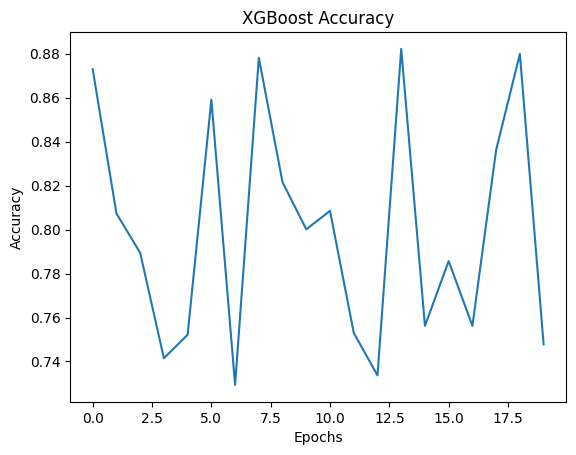

In [28]:
plt.plot(range(20), clf_cat_xgboost_scores)
plt.title('XGBoost Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [29]:
best_hyperparameters

{'alpha': 0.007545319602241652,
 'colsample_bylevel': 0.9341343721174034,
 'colsample_bytree': 0.966385266302286,
 'gamma': 1.4771480361259994,
 'lambda': 1.251232044956577,
 'learning_rate': 0.09479197333851368,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'n_estimators': 3800.0,
 'subsample': 0.8031415248129838}

In [31]:
trials.best_trial

{'state': 2,
 'tid': 13,
 'spec': None,
 'result': {'loss': -0.8821490467937608, 'status': 'ok'},
 'misc': {'tid': 13,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'alpha': [13],
   'colsample_bylevel': [13],
   'colsample_bytree': [13],
   'gamma': [13],
   'lambda': [13],
   'learning_rate': [13],
   'max_depth': [13],
   'min_child_weight': [13],
   'n_estimators': [13],
   'subsample': [13]},
  'vals': {'alpha': [0.007545319602241652],
   'colsample_bylevel': [0.9341343721174034],
   'colsample_bytree': [0.966385266302286],
   'gamma': [1.4771480361259994],
   'lambda': [1.251232044956577],
   'learning_rate': [0.09479197333851368],
   'max_depth': [9.0],
   'min_child_weight': [2.0],
   'n_estimators': [3800.0],
   'subsample': [0.8031415248129838]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 5, 17, 4, 23, 28, 863000),
 'refresh_time': datetime.datetime(2024, 5, 17, 4, 23, 32, 245000)}